Perform error analysis across activities.

In [1]:
import math
import copy
import pickle

import pathlib as pl
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np

from scipy.stats import wilcoxon, shapiro, stats
from effsize.effsize import two_group_difference

from utils import plot_comparison, pick_colors

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
# Visuals in paper theme, with larger font and thicker lines.
sns.set_theme()
sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2.5})

### Define paths.

In [4]:
# Inputs.
transitions_pickle_file = pl.Path(
    '../processed_data/justhink21_transitions.pickle')
submissions_pickle_file = pl.Path(
    '../processed_data/justhink21_submissions.pickle')

# Outputs.
collab_best_pickle_file = pl.Path(
    '../processed_data/collab_best_df.pickle')
cdf_human_pickle_file = pl.Path(
    '../processed_data/cdf_human.pickle')
figs_dir = pl.Path('../figures')

### Load submission tables.

In [5]:
with submissions_pickle_file.open('rb') as handle:
    submissions = pickle.load(handle)

# Example:
submissions_df = submissions['all'].reset_index(drop=True)
submissions_df.head()

,participant,time,activity,state,next_state,action,attempt_no,cost,opt_cost,error,is_mst,is_spanning
0,1,161.277439,pretest-1,"EnvironmentState(NetworkState(e:7+0,c:23|n:7,e...","EnvironmentState(NetworkState(e:7+0,c:23|n:7,e...","Action(submit,Human)",1,23,15,0.533333,False,True
1,1,251.009743,pretest-2,"EnvironmentState(NetworkState(e:7+0,c:38|n:7,e...","EnvironmentState(NetworkState(e:7+0,c:38|n:7,e...","Action(submit,Human)",1,38,30,0.266667,False,True
2,1,319.224974,pretest-3,"EnvironmentState(NetworkState(e:6+0,c:22|n:7,e...","EnvironmentState(NetworkState(e:6+0,c:22|n:7,e...","Action(submit,Human)",1,22,21,0.047619,False,True
3,1,386.282414,pretest-4,"EnvironmentState(NetworkState(e:6+0,c:45|n:7,e...","EnvironmentState(NetworkState(e:6+0,c:45|n:7,e...","Action(submit,Human)",1,45,45,0.000000,True,True
4,1,435.368411,pretest-5,"EnvironmentState(NetworkState(e:6+0,c:15|n:7,e...","EnvironmentState(NetworkState(e:6+0,c:15|n:7,e...","Action(submit,Human)",1,15,15,0.000000,True,True


### Load transition tables.

In [6]:
with transitions_pickle_file.open('rb') as handle:
    transitions = pickle.load(handle)


# # Example:
# transitions.keys()
# pd.options.display.max_columns = None
# df = transitions[9]
# df = df.loc[df['activity'] == 'collaboration-2']
# df.head()

## 1. Compare performance across collaborative activities.

- Compare errors of best attempt in activity 1 vs. best attempt in activity 2 by Wilcoxon’s, and compute effect size Cliff’s Delta) (extension of notebook 3)
    - evolution overall significant if Wilcoxon’s says p < 0.05. 
    - Direction (improve or not) by Cliff’s Delta’s sign.
- Note: must be spanning, for collaborative activities
- report Magnitude overall: Cliff’s Delta’s absolute value (large, small, negligible, etc.)

### Annotate human and best submissions.

In [7]:
# Annotate human submissions.
submissions_df['is_human'] = \
    [action.agent.name == 'Human' for action in submissions_df.action]

# Annotate best submissions of each activity.
# (tests are trivial as there is only one submission allowed).
submissions_df['is_best'] = False
for p in submissions_df.participant.unique():
    df = submissions_df[submissions_df.participant == p]
    for a in df.activity.unique():
        dff = df[df.activity == a]
        min_index = dff.error.idxmin()
        if not math.isnan(min_index):
            submissions_df.loc[min_index, 'is_best'] = True

# Check if all best submissions are human.
for i, row in submissions_df.iterrows():
    if row.is_best:
        assert row.is_human


# submissions_df.head()

### Annotate first and last submissions.

In [8]:
# Annotate first and last submissions of each activity.
# (tests are trivial as there is only one submission allowed).
submissions_df['is_first'] = False
submissions_df['is_last'] = False
for p in submissions_df.participant.unique():
    df = submissions_df[submissions_df.participant == p]
    for a in df.activity.unique():
        dff = df[df.activity == a]
        # Only consider th human submissions.
        dff = dff[dff.is_human]
        
        min_index = dff.index[0]
        submissions_df.loc[min_index, 'is_first'] = True

        max_index = dff.index[-1]
        submissions_df.loc[max_index, 'is_last'] = True

### Compare error over best submissions in collaborative activities.

#### Make a best submissions table.

In [9]:
df = submissions_df.copy()
best_df = df[df.is_best]
activities = ['collaboration-1', 'collaboration-2']
best_df = best_df[best_df.activity.isin(activities)]
best_df.drop(columns=['is_best', 'is_human'], inplace=True)
best_df = best_df.pivot(index='participant', columns='activity')

best_df[['attempt_no', 'error', 'is_mst', 'is_spanning']]

attempt_no                           error                  \
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2   
participant                                                                   
1                       2.0             3.0        0.318182        0.000000   
2                       1.0             6.0        0.000000        0.000000   
3                       3.0             2.0        0.000000        0.057143   
4                       2.0             3.0        0.318182        0.000000   
5                       3.0             1.0        0.318182        0.000000   
6                       1.0             1.0        0.772727        0.542857   
7                       2.0             NaN        0.000000             NaN   
8                       3.0             2.0        0.045455        0.000000   
9                       1.0             1.0        0.000000        0.000000   

                     is_mst                     is_spanning                  
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2  
participant                                                                  
1                     False            True            True            True  
2                      True            True            True            True  
3                      True           False            True            True  
4                     False            True            True            True  
5                     False            True            True            True  
6                     False           False            True            True  
7                      True             NaN            True             NaN  
8                     False            True            True            True  
9                      True            True            True            True

#### Plot best submissions.

../figures/performance_best.pdf


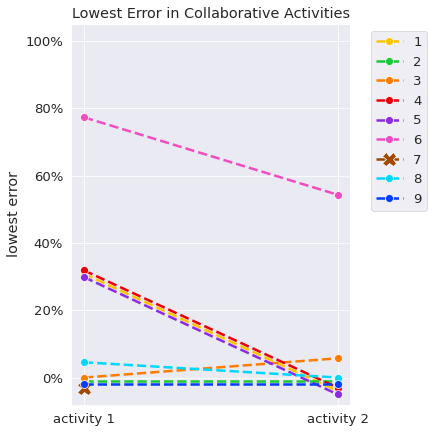

In [10]:
# Define function to retrieve and plot the feasible scores.
def get_errors_from_row(row):
    e1 = row['error']['collaboration-1']
    e2 = row['error']['collaboration-2']
    return (e1, e2)


def plot_best(best_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    # participants = [8, 2, 9, 6, 7, 1, 5, 4, 3]
    participants = [3, 8, 2, 9, 6, 7, 4, 1, 5]

    # Plot the changes from pre-test to post-test.
    export_file = figs_dir.joinpath('performance_best.pdf')
    # xvalues = ['collaborative 1', 'collaborative 2']
    xvalues = ['activity 1', 'activity 2']
    plot_comparison(
        best_df, participants=participants, xvalues=xvalues,
        ylabel='lowest error', verbose=verbose,
        title='Lowest Error in Collaborative Activities',
        yticks=True, offset=0.01, ygrid=True,
        export_file=export_file,
        getter=get_errors_from_row, ax=ax, save=save)


plot_best(best_df, verbose=False)

#### Perform Wilcoxon signed-rank test and compute the effect size (estimated by Cliff's delta).

In [11]:
r = list()
o = list()
df = best_df.dropna()
for i, row in df.iterrows():
    v1, v2 = get_errors_from_row(row)
    r.append(v1)
    o.append(v2)

print('r:', ['{:.3f}'.format(val) for val in r])
print('o:', ['{:.3f}'.format(val) for val in o])

print('Shapiro:')
print('r:', shapiro(r))
print('o:', shapiro(o))

# Null hypothesis says they are the same:
# if p val less than threshold, reject hypothesis and
# conclude that activity 1 best and activity 2 best are different.
w, p = wilcoxon(r, o, mode='exact')
print('Exact:', 'W=', w, 'pvalue=', p)

# Estimate effect size by Cliff's Delta.
d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
print('d', d)

r: ['0.318', '0.000', '0.000', '0.318', '0.318', '0.773', '0.045', '0.000']
o: ['0.000', '0.000', '0.057', '0.000', '0.000', '0.543', '0.000', '0.000']
Shapiro:
r: ShapiroResult(statistic=0.8012939691543579, pvalue=0.029552701860666275)
o: ShapiroResult(statistic=0.4747297763824463, pvalue=5.114766736369347e-06)
Exact: W= 2.0 pvalue= 0.07154597258900632
d -0.375


/home/utku/playground/data-justhink-spring21/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/utku/playground/data-justhink-spring21/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Compare error over first and last submissions in collaborative activities.

#### Make a first-last submissions table.

In [12]:
df = submissions_df.copy()
# Get the first of activity 1 and last of activity 2.
df = df[
    (df.is_first & (df.activity == 'collaboration-1')) | \
    (df.is_last & (df.activity == 'collaboration-2'))]
comp_df = df
# comp_df.drop(columns=['is_best', 'is_human'], inplace=True)
comp_df = comp_df.pivot(index='participant', columns='activity')

comp_df[['error', 'is_mst', 'is_spanning', 'attempt_no']]

error                          is_mst                  \
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2   
participant                                                                   
1                  0.318182        0.000000           False            True   
2                  0.000000        0.000000            True            True   
3                  0.318182        0.114286           False           False   
4                  0.454545        0.000000           False            True   
5                  0.318182        0.000000           False            True   
6                  0.772727             NaN           False           False   
7                       NaN             NaN           False           False   
8                  0.454545        0.000000           False            True   
9                  0.000000        0.000000            True            True   

                is_spanning                      attempt_no                  
activity    collaboration-1 collaboration-2 collaboration-1 collaboration-2  
participant                                                                  
1                      True            True               2               3  
2                      True            True               1               6  
3                      True            True               2               3  
4                      True            True               1               3  
5                      True            True               3               1  
6                      True           False               1               4  
7                     False           False               1               4  
8                      True            True               1               2  
9                      True            True               1               1

#### Plot first-last submissions.

../figures/performance_first_to_last.pdf


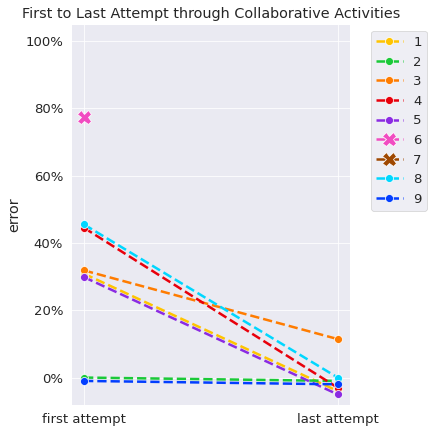

In [13]:
def plot_firstlast(comp_df, ax=None, save=True, verbose=False):
    # Order participants to have aligned offsets of repeating values.
    # participants = [8, 2, 9, 6, 7, 1, 5, 4, 3]
    participants = [3, 8, 2, 9, 6, 7, 4, 1, 5]

    # Plot the changes from pre-test to post-test.
    export_file = figs_dir.joinpath('performance_first_to_last.pdf')
    xvalues = ['first attempt', 'last attempt']
    plot_comparison(
        comp_df, participants=participants, xvalues=xvalues,
        ylabel='error', verbose=verbose,
        title='First to Last Attempt through Collaborative Activities',
        yticks=True, offset=0.01, ygrid=True,
        export_file=export_file,
        getter=get_errors_from_row, ax=ax, save=save)


plot_firstlast(comp_df, verbose=False)

#### Perform Wilcoxon signed-rank test and compute the effect size (estimated by Cliff's delta).

In [14]:
r = list()
o = list()
df = comp_df.dropna()
for i, row in df.iterrows():
    v1, v2 = get_errors_from_row(row)
    r.append(v1)
    o.append(v2)

print('r:', ['{:.3f}'.format(val) for val in r])
print('o:', ['{:.3f}'.format(val) for val in o])

print('Shapiro:')
print('r:', shapiro(r))
print('o:', shapiro(o))

# Null hypothesis says they are the same:
# if p val less than threshold, reject hypothesis and
# conclude that activity 1 best and activity 2 best are different.
w, p = wilcoxon(r, o, mode='exact', zero_method='pratt')
print('Exact:', 'W=', w, 'pvalue=', p)

# Estimate effect size by Cliff's Delta.
d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
print('d', d)

r: ['0.318', '0.000', '0.318', '0.455', '0.318', '0.455', '0.000']
o: ['0.000', '0.000', '0.114', '0.000', '0.000', '0.000', '0.000']
Shapiro:
r: ShapiroResult(statistic=0.8026725053787231, pvalue=0.0435309000313282)
o: ShapiroResult(statistic=0.4529709219932556, pvalue=4.135582003073068e-06)
Exact: W= 0.0 pvalue= 0.03079814277617586
d -0.6734693877551021


/home/utku/playground/data-justhink-spring21/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/utku/playground/data-justhink-spring21/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


## 2. Compare performance over submissions.

### Make a simplified submissions table for plotting.

In [15]:
df = submissions_df.copy()
# Check if all best submissions are human.
for i, row in df.iterrows():
    if row.is_best:
        assert row.is_human
cols = ['participant', 'activity', 'error', 'attempt_no', 'is_best']
df = df[cols]
df = df[df.is_best]
df.drop(columns=['is_best'], inplace=True)
# df.set_index('participant', inplace=True)
# df.pivot('participant', columns='activity') #, inplace=True)
best_submissions_df = df

# best_submissions_df

In [16]:
activity_renamer = dict()
for a in submissions_df.activity.unique():
    new = a
    new = new.replace('test', '')
    new = new.replace('collaboration', 'collab')
    activity_renamer[a] = new

activity_renamer

{'pretest-1': 'pre-1',
 'pretest-2': 'pre-2',
 'pretest-3': 'pre-3',
 'pretest-4': 'pre-4',
 'pretest-5': 'pre-5',
 'collaboration-1': 'collab-1',
 'collaboration-2': 'collab-2',
 'posttest-1': 'post-1',
 'posttest-2': 'post-2',
 'posttest-3': 'post-3',
 'posttest-4': 'post-4',
 'posttest-5': 'post-5'}

### Visualize the complete evolution.

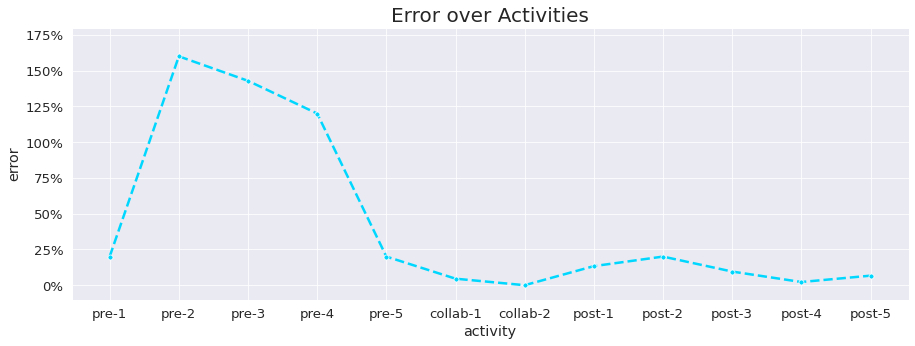

In [17]:
def plot_evolution(
        evolution_df, color, label,
        ax=None, ylabel='error', ylim=(-0.1, 1.8)):
    """helper function to graph each student dataframe 
    on same plot, takes dataframe as input"""
    temp = evolution_df

    if ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))

    # visualization for error evolution over the best submission in each collaborative activity
    # students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
    # separation = 0.01

    # graphing the pretest versus posttest is_spanning scores

    # Plot.
    size = 5
    marker = 'o'
    sns.lineplot(
        x=temp.activity, y=temp.error, marker=marker, ms=size,
        ls='--', color=color, label=label,
        legend=False, ax=ax)

    # title = 'Evolution of All Students'
    title = 'Error over Activities'

    ax.set_title(title, loc='center', fontsize=20)

    # leg = plt.legend(evolution_dfs.keys(), loc='upper right', frameon=True)
    # # ensure that y-axis labelling is proportional to maximum possible error
    # plt.ylim(-0.1, 2.2)  # max_error[1])
    # locs, labels = plt.yticks()
    # labels = [str(round(i*100)) + '%' for i in locs]
    # labels[0] = ''
    # plt.yticks(locs, labels)

    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])


participant = 8
colors = pick_colors()
df = best_submissions_df.copy()
df = df[df.participant == participant]
df.activity = [activity_renamer[a] for a in df.activity]

plot_evolution(df, color=colors[participant], label=str(str(participant)))

../figures/performance_evolution.pdf


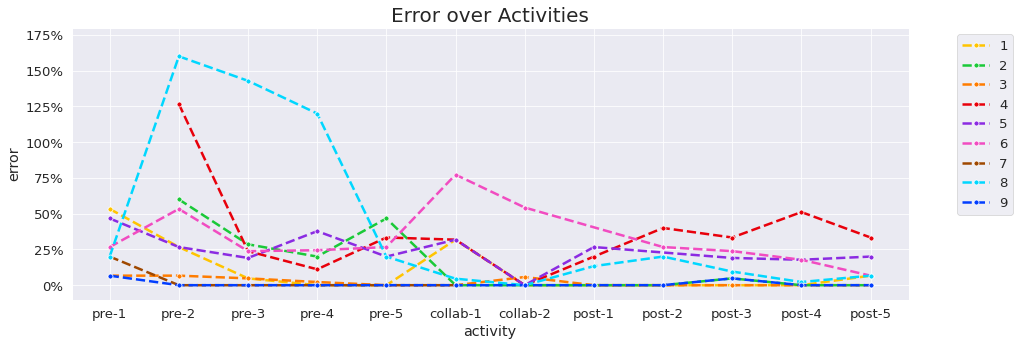

In [19]:
def plot_all_evolutions(submissions_df, export_file=None):
    participants = range(1, 10)  # [9, 1, 2, 3, 7, 4, 8, 5, 6]

    fig, ax = plt.subplots(1, figsize=(15, 5))

    colors = pick_colors()
    for p in participants:
        df = submissions_df.copy()
        df = df[df.participant == p]
        df.activity = [activity_renamer[a] for a in df.activity]

        plot_evolution(df, ax=ax, color=colors[p], label=str(str(p)))
        

    leg = plt.legend(sorted(participants), loc='upper left', frameon=True)
    # Get the bounding box of the original legend.
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    # Change to location of the legend.
    x_offset = 1.05
    bb.x0 = bb.x0 + x_offset
    bb.x1 = bb.x1 + x_offset
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

    if export_file is not None:
        plt.savefig(export_file, bbox_inches='tight')
        print(export_file)
        
        
export_file = figs_dir.joinpath('performance_evolution.pdf')
plot_all_evolutions(best_submissions_df, export_file=export_file)

# submissions_df[['participant', 'activity', 'error']]
# plot_all_evolutions(submissions_df)